# Sesión 2 Apartado 4: GridSearchCV

Objetivo: Ajuste de hiperparámetros con GridSearchCV, interpretación y buenas prácticas.

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

X, y = make_classification(n_samples=800, n_features=15, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

## ¿Qué es GridSearchCV?

GridSearchCV realiza una búsqueda exhaustiva sobre una cuadrícula de hiperparámetros indicada por `param_grid`. Para cada combinación, realiza validación cruzada (parámetro `cv`) y devuelve el mejor conjunto según la métrica `scoring`.

Puntos clave:
- `cv`: número/estrategia de folds (usar `StratifiedKFold` para clasificación desbalanceada).
- `scoring`: métrica única o un diccionario de métricas. Si pasas varias, usa `refit` para indicar cuál optimizar.
- `n_jobs`: paraleliza el proceso.
- `refit=True` (o nombre de métrica): reentrena el mejor modelo sobre todo el conjunto de entrenamiento con los hiperparámetros óptimos.

Buenas prácticas:
- Inserta `Pipeline` si necesitas preprocesado (evita fugas de información).
- Para búsquedas grandes considera `RandomizedSearchCV`.
- Para evaluar generalización de la selección de hiperparámetros usa `nested CV`.

## Ejemplo: RandomForest
Probamos `n_estimators` y `max_depth`.

Best params (RF): {'max_depth': 5, 'n_estimators': 50}
Best score (RF): 0.9685629571917067

Classification report (RF best on test):

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       104
           1       0.97      0.96      0.96        96

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200


Classification report (RF best on test):

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       104
           1       0.97      0.96      0.96        96

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200



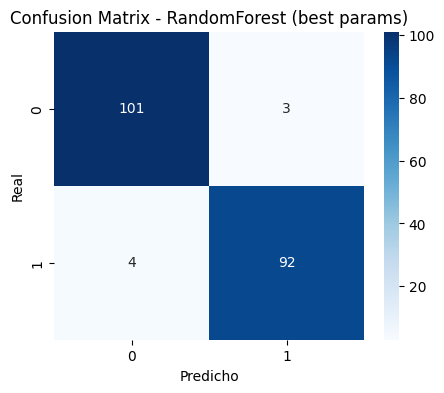

In [2]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=2), param_grid, cv=4, scoring='f1', n_jobs=-1, refit=True)
grid_rf.fit(X_train, y_train)
print('Best params (RF):', grid_rf.best_params_)
print('Best score (RF):', grid_rf.best_score_)

# Matriz de confusión en test con el mejor estimador
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

best_rf = grid_rf.best_estimator_
y_pred_test = best_rf.predict(X_test)
print('\nClassification report (RF best on test):\n')
print(classification_report(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - RandomForest (best params)')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

## Ejemplo: SVM
Buscamos `C` y `kernel`.

Mejor f1: 0.9651
Mejor accuracy: 0.9650

Mejor métrica global: f1
Mejores parámetros según f1 : {'C': 1, 'kernel': 'linear'}

Classification report (SVM best on test):

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       104
           1       0.97      0.95      0.96        96

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



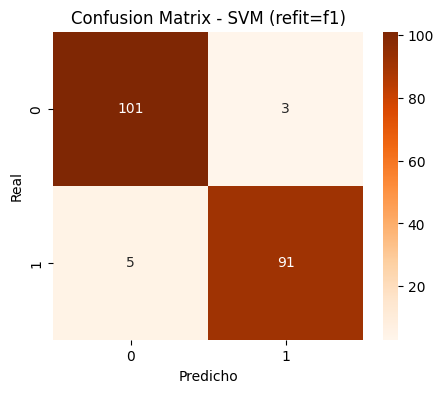

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

param_grid_svm = {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}

scoring = {"f1": "f1", "accuracy": "accuracy"}

# Ponemos refit=False, porque lo haremos manualmente
grid_svm = GridSearchCV(
    SVC(probability=True), param_grid_svm, cv=4, scoring=scoring, refit=False, n_jobs=-1
)
grid_svm.fit(X_train, y_train)

best_metric = {}
cv_results = grid_svm.cv_results_
for metric in scoring.keys():
    test_key = f"mean_test_{metric}"
    best_metric[metric] = cv_results[test_key].max()
    print(f"Mejor {metric}: {cv_results[test_key].max():.4f}")

best_metric = max(best_metric, key=best_metric.get)
print(f"\nMejor métrica global: {best_metric}")

best_index = cv_results[f"rank_test_{best_metric}"].argmin()
best_params = cv_results["params"][best_index]
print("Mejores parámetros según", best_metric, ":", best_params)

best_svm = SVC(probability=True, **best_params)
best_svm.fit(X_train, y_train)

y_pred_svm = best_svm.predict(X_test)
print("\nClassification report (SVM best on test):\n")
print(classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title(f"Confusion Matrix - SVM (refit={best_metric})")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()